# NBA Win Probability — Single Game Generator

This notebook takes an NBA `game_id` and a pair of **pregame implied win probabilities**, downloads all required data from the NBA Stats API, builds a full game-state timeline, runs each state through a trained neural-network win probability model, and produces a complete **win probability chart** for that game.

**What this notebook does:**
- Downloads play-by-play and game summary data for a single game  
- Constructs standardized game-state features  
- Adds pregame `home_win_implied_prob` and `away_win_implied_prob`  
- Computes engineered time features (`t_log`, `t_inv`)  
- Loads the trained win probability model and generates calibrated probabilities  
- Produces a win-probability graph from tipoff to final buzzer  

**Inputs:**
- `game_id` (string)  
- `home_win_implied_prob`, `away_win_implied_prob` (floats)

**Output:**
- Full win probability curve for the selected game.


In [411]:
# === NBA API ===
from nba_api.stats.endpoints import (
    playbyplayv3,
    boxscoresummaryv2,
    boxscoretraditionalv3,
    boxscoresummaryv3,
    leaguegamelog
)

# === Data Processing ===
import pandas as pd
import numpy as np
import re
import os

# === Machine Learning ===
import torch
from torch import nn
import joblib

# === Graphing ===
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [ ]:
# EDIT THESE
GAME_ID = "0022500262"              # Example. You can use function get_game_ids_on_date to find game IDs.
HOME_TEAM_MONEYLINE = 240           # Example
AWAY_TEAM_MONEYLINE = -300          # Example

# EDIT THESE OR LEAVE AS DEFAULT IF IN SAME FOLDER
AUX_PATH = "nn_winprob_aux.pkl"     # Default
MODEL_PATH = "nn_winprob_model.pt"  # Default
if not os.path.exists(AUX_PATH):
    raise FileNotFoundError(f"Aux file not found: {AUX_PATH}")
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"Model file not found: {MODEL_PATH}")

In [485]:
# Use this to find games on a given date!
def get_game_ids_on_date(date_str: str) -> pd.DataFrame:
    """
    Returns a DataFrame of game logs for the given date (YYYY-MM-DD),
    including game IDs, home/away teams, and other basic info.
    """
    # leaguegamelog returns recent games; you can filter by date
    def get_nba_season(date_str: str) -> str:
        """
        Given a date string 'YYYY-MM-DD', return the NBA season string 'YYYY-YY'.
        Example: '2025-11-13' -> '2025-26'
                 '2023-03-24' -> '2022-23'
        """
        year, month, _ = map(int, date_str.split("-"))

        if month >= 10:  # October, November, December → start of new season
            start_year = year
            end_year = year + 1
        else:            # January–September → still in last season
            start_year = year - 1
            end_year = year

        # Format like "2025-26" (only last 2 digits of end year)
        return f"{start_year}-{str(end_year)[-2:]}"
    season = get_nba_season(date_str)
    log = leaguegamelog.LeagueGameLog(season=season, season_type_all_star='Regular Season').get_data_frames()[0]
    # Filter for the given date
    df = log[log['GAME_DATE'] == date_str].copy()
    return df[['GAME_ID', 'GAME_DATE', 'MATCHUP', 'WL', 'PTS', 'PLUS_MINUS']]



# Example usage
date = "2025-11-19"
games_on_date = get_game_ids_on_date(date)
print(games_on_date)

        GAME_ID   GAME_DATE      MATCHUP WL  PTS  PLUS_MINUS
426  0022500255  2025-11-19    HOU @ CLE  W  114          10
427  0022500256  2025-11-19  IND vs. CHA  W  127           9
428  0022500258  2025-11-19    TOR @ PHI  W  121           9
429  0022500256  2025-11-19    CHA @ IND  L  118          -9
430  0022500255  2025-11-19  CLE vs. HOU  L  104         -10
431  0022500260  2025-11-19  NOP vs. DEN  L  118          -7
432  0022500259  2025-11-19    WAS @ MIN  L  109         -11
433  0022500261  2025-11-19  OKC vs. SAC  W  113          14
434  0022500260  2025-11-19    DEN @ NOP  W  125           7
435  0022500259  2025-11-19  MIN vs. WAS  W  120          11
436  0022500258  2025-11-19  PHI vs. TOR  L  112          -9
437  0022500257  2025-11-19    GSW @ MIA  L   96         -14
438  0022500257  2025-11-19  MIA vs. GSW  W  110          14
439  0022500261  2025-11-19    SAC @ OKC  L   99         -14
440  0022500262  2025-11-19    NYK @ DAL  W  113           2
441  0022500263  2025-11

### Many Helper Functions Below. Skip to the bottom to see the graphs!

In [486]:
def fix_scores_carry_forward(df: pd.DataFrame) -> pd.DataFrame:
    """
    For each game, carry forward the last non-zero scoreHome/scoreAway.
    Assumes df is already sorted in chronological PBP order within each game.
    Recomputes score_diff at the end.
    """
    df = df.copy()
    score_cols = ["scoreHome", "scoreAway"]  # or whatever your score columns are

    for col in score_cols:
        # Convert to numeric, turn '' and other junk into NaN
        df[col] = pd.to_numeric(df[col], errors="coerce")
    
        # Forward fill within the game, then fill any leading NaNs with 0
        df[col] = df[col].ffill().fillna(0).astype(int)
    # Decide how to group (per game or whole df)
    if "gameId" in df.columns:
        group_cols = ["gameId"]
    elif "game_id" in df.columns:
        group_cols = ["game_id"]
    else:
        group_cols = None  # assume df is already a single game

    def _fix_one_game(g: pd.DataFrame) -> pd.DataFrame:
        # If you want to be extra safe, you can sort inside each game
        # by period/time/event_num, e.g.:
        # sort_cols = [c for c in ["period", "event_num"] if c in g.columns]
        # if sort_cols:
        #     g = g.sort_values(sort_cols)

        for col in ["scoreHome", "scoreAway"]:
            if col in g.columns:
                g[col] = (
                    g[col]
                    .replace(0, np.nan)  # treat 0 as "missing" between scores
                    .ffill()             # carry forward last known score
                    .fillna(0)           # before first score, keep 0-0
                    .astype(int)
                )

        # Recompute score_diff if present / desired
        if "scoreHome" in g.columns and "scoreAway" in g.columns:
            g["score_diff"] = g["scoreHome"] - g["scoreAway"]

        return g

    if group_cols is None:
        df = _fix_one_game(df)
    else:
        df = df.groupby(group_cols, group_keys=False).apply(_fix_one_game)

    return df

In [487]:
def american_to_implied_prob(odds):
    """
    Convert American odds to implied probability (no vig removal).
    """
    if pd.isna(odds):
        return np.nan

    odds = float(odds)

    if odds < 0:
        return (-odds) / ((-odds) + 100)
    else:
        return 100 / (odds + 100)

In [488]:
def parse_iso_clock_to_seconds(clock_str) -> int:
    """
    Parse PlayByPlayV3 'clock' strings like 'PT11M54.00S' into seconds.
    """
    if clock_str is None or pd.isna(clock_str):
        return 0

    s = str(clock_str).strip()
    if not s.startswith("PT"):
        return 0

    # Strip 'PT' and trailing 'S'
    s = s[2:]
    if s.endswith("S"):
        s = s[:-1]

    # Split on 'M'
    if "M" not in s:
        return 0

    minutes_str, seconds_str = s.split("M", 1)

    try:
        minutes = int(float(minutes_str))
    except ValueError:
        minutes = 0

    try:
        seconds = int(float(seconds_str))
    except ValueError:
        seconds = 0

    return minutes * 60 + seconds


def add_time_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add:
      - seconds_remaining_in_period: time left in the current period
      - seconds_remaining_game: time left until this period ends, assuming
        the game ends at 0:00 of this period (i.e., end of Q4 or an OT)

    For periods 1–4, seconds_remaining_game is "time left in regulation".
    For periods > 4 (OTs), seconds_remaining_game is just the clock time left
    in that OT period.
    """
    df = df.copy()

    # 1) Seconds remaining in current period from the ISO clock
    df["seconds_remaining_in_period"] = df["clock"].apply(parse_iso_clock_to_seconds)

    period_length = 12 * 60        # 12-minute quarters
    total_reg = 4 * period_length  # 48 minutes

    def compute_seconds_remaining_game(row):
        period = row["period"]
        sec_left = row["seconds_remaining_in_period"]

        if period <= 4:
            # Time elapsed before this period
            elapsed_before = (period - 1) * period_length
            # Time elapsed within this period
            elapsed_in_period = period_length - sec_left
            elapsed_total = elapsed_before + elapsed_in_period
            # Time left in regulation
            return max(0, total_reg - elapsed_total)
        else:
            # In any OT, treat "time remaining until game ends" as just
            # the time left in this OT period.
            return sec_left

    df["seconds_remaining_game"] = df.apply(compute_seconds_remaining_game, axis=1)

    return df

In [489]:
def add_score_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Ensure scores are numeric, forward-filled, and add score_diff (home - away).
    """
    df = df.copy()

    # Some rows may have None / NaN scores; convert and forward fill.
    df["scoreHome"] = pd.to_numeric(df["scoreHome"], errors="coerce")
    df["scoreAway"] = pd.to_numeric(df["scoreAway"], errors="coerce")

    df["scoreHome"] = df["scoreHome"].ffill().fillna(0).astype(int)
    df["scoreAway"] = df["scoreAway"].ffill().fillna(0).astype(int)

    df["score_diff"] = df["scoreHome"] - df["scoreAway"]

    return df

In [490]:
def add_outcome_label(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add a binary label 'home_win' for each row based on final score.
    """
    df = df.copy()

    # Look at the last non-null score row to determine result
    final_home = df["scoreHome"].iloc[-1]
    final_away = df["scoreAway"].iloc[-1]

    home_win = int(final_home > final_away)
    df["home_win"] = home_win

    return df

In [491]:
def get_home_away_team_ids(game_id: str):
    summary = boxscoresummaryv2.BoxScoreSummaryV2(game_id=game_id)
    game_summary = summary.game_summary.get_data_frame().iloc[0]

    home_team_id = int(game_summary["HOME_TEAM_ID"])
    away_team_id = int(game_summary["VISITOR_TEAM_ID"])
    return home_team_id, away_team_id

In [492]:
def parse_free_throw_subtype(sub_type: str):
    """
    Parse subType strings like:
      'Free Throw 1 of 2'
      'Free Throw 2 of 2'
      'Free Throw Flagrant 1 of 2'
      'Free Throw Flagrant 2 of 2'

    Returns:
      (idx, total) as ints, or (None, None) if no match.

    If we later encounter patterns like 'Free Throw Technical' with no
    'X of Y', we can treat them as (1,1).
    """
    if not isinstance(sub_type, str):
        return None, None

    s = sub_type.strip()
    s = re.sub(r"\s+", " ", s)  # normalize whitespace

    # General pattern: "Free Throw [optional word(s)] X of Y"
    # e.g. "Free Throw 1 of 2", "Free Throw Flagrant 1 of 2"
    m = re.search(r"Free Throw.*?(\d+)\s+of\s+(\d+)", s, flags=re.IGNORECASE)
    if m:
        idx = int(m.group(1))
        total = int(m.group(2))
        return idx, total

    # Fallback: something like "Free Throw Technical" → treat as 1 of 1
    if "free throw" in s.lower():
        return 1, 1

    return None, None

In [493]:
def _loc_to_sign(loc_value: str) -> int:
    """
    Map PlayByPlayV3 'location' field to +1 (home), -1 (away), or 0 (neutral).

    Adjust this mapping if your actual 'location' values differ.
    """
    if loc_value is None or pd.isna(loc_value):
        return 0
    s = str(loc_value).strip().lower()

    # Common patterns: 'home', 'away', but tweak if you see others
    if s in ("home", "hom", "h"):
        return 1
    if s in ("away", "awy", "visitor", "vis", "v"):
        return -1
    return 0

def add_free_throw_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add:
      - home_ft_remaining
      - away_ft_remaining

    Semantics: at each row, these give the number of free throws still to be
    taken by each team *after* this event.

    Logic:
      - Identify free throw rows by actionType containing 'Free Throw'.
      - Parse subType ('Free Throw 1 of 2', 'Free Throw Flagrant 1 of 2', etc.)
      - remaining = max(0, total - idx)
      - If the shooter is home:  home_ft_remaining = remaining
      - If the shooter is away: away_ft_remaining = remaining
      - Non-FT rows keep the previous remaining values.
    """
    df = df.copy()

    # Ensure we have location_sign
    if "location_sign" not in df.columns:
        df["location_sign"] = df["location"].apply(_loc_to_sign)

    action_types = df["actionType"].fillna("").astype(str)

    home_ft_rem = 0
    away_ft_rem = 0

    home_ft_remaining = []
    away_ft_remaining = []

    for i in range(len(df)):
        atype = action_types.iat[i].lower()
        loc_sign = df["location_sign"].iat[i]

        # If this row is a free throw, update the counters based on subType
        if "free throw" in atype:
            sub_type = df["subType"].iat[i]
            idx, total = parse_free_throw_subtype(sub_type)

            if idx is not None and total is not None:
                remaining = max(0, total - idx)
                if loc_sign == 1:
                    # Home shooting FTs
                    home_ft_rem = remaining
                elif loc_sign == -1:
                    # Away shooting FTs
                    away_ft_rem = remaining
                # If loc_sign == 0, we ignore (weird neutral FT case)
        # For non-FT rows, we just carry over current home_ft_rem / away_ft_rem

        # Record the state *after* this event
        home_ft_remaining.append(home_ft_rem)
        away_ft_remaining.append(away_ft_rem)

    df["home_ft_remaining"] = home_ft_remaining
    df["away_ft_remaining"] = away_ft_remaining

    # You can keep or drop location_sign depending on whether you use it elsewhere
    # df.drop(columns=["location_sign"], inplace=True)

    return df

def add_possession_after(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add a 'possession' column representing who has the ball AFTER each event,
    from the home team's perspective:

        possession ∈ {+1, 0, -1}
          +1 = home has ball
          -1 = away has ball
           0 = no clear possession (end of period, jump ball, game over, etc.)

    Logic:
      - Look ahead from each row to the next relevant action:
          * Skip Substitution / Timeout rows
          * If next is Foul: invert the location team
          * If next is period / Jump Ball: set possession = 0
          * Else: possession = location of that next row (home/away)
      - For rows that are themselves period / Jump Ball: possession = 0
    """
    df = df.copy()

    # Precompute a simple sign for each row's location
    df["location_sign"] = df["location"].apply(_loc_to_sign)

    n = len(df)
    possession_after = [0] * n

    action_types = df["actionType"].fillna("").astype(str)

    for i in range(n):
        atype_i = action_types.iat[i].lower()

        # If this row itself is end-of-period or a jump ball, possession is 0
        if "period" in atype_i or "jump ball" in atype_i:
            possession_after[i] = 0
            continue
        if "rebound" in atype_i:
            possession_after[i] = df["location_sign"].iat[i]
            continue
        # Look ahead to find the next relevant offensive action
        poss = 0
        j = i + 1
        while j < n:
            atype_j = action_types.iat[j].lower()
            loc_sign_j = df["location_sign"].iat[j]

            # Skip subs/timeouts when searching
            if "substitution" in atype_j or "timeout" in atype_j:
                j += 1
                continue

            # If the next significant event is end-of-period or jump ball → no possession
            if "period" in atype_j or "jump ball" in atype_j:
                poss = 0
                break

            # If the next event is a foul, invert the fouling team to get offense
            if "foul" in atype_j:
                if loc_sign_j == 1:
                    poss = -1
                elif loc_sign_j == -1:
                    poss = 1
                else:
                    poss = 0
                break

            # Otherwise, treat the next event's team as having the ball
            if loc_sign_j != 0:
                poss = loc_sign_j
                break

            # If location is neutral/unknown, keep scanning
            j += 1

        possession_after[i] = poss

    df["possession"] = possession_after
    # Optionally drop helper
    df.drop(columns=["location_sign"], inplace=True)

    return df

In [494]:
def filter_to_state_rows(df: pd.DataFrame) -> pd.DataFrame:
    """
    Keep only rows where we want to define a model state.

    States are:
      - After a MADE field goal
      - After a rebound (except 'Normal Rebound' pseudo-events)
      - After a turnover
      - After dead-ball / possession-setting events (fouls, timeouts, violations, OOB, etc.)
      - During free throws that are NON-REBOUNDABLE on a miss
        (all pre-final FTs in a trip, plus flagrant/technical FTs)
      - During reboundable FTs *only if made* (missed ones defer to the rebound row)

    We DROP:
      - Missed normal field goals (state comes at rebound/dead-ball)
      - Missed reboundable FTs (state comes at rebound)
      - Duplicate offensive-foul rows
      - Fake 'Normal Rebound' rows after non-reboundable FTs
    """
    df = df.copy()

    def _is_state_row(row) -> bool:
        atype = str(row["actionType"]).lower()
        sub_raw = row.get("subType", "")
        sub = str(sub_raw).strip()
        poss  = row["possession"]
        sub_type = str(sub_raw)
        sub_lower = sub_type.lower()
        if atype == "made shot":
            return True
        # 1) Remove offensive-charge duplicate foul rows
        if sub == "Offensive Charge":
            return False

        # 2) Remove fake team rebounds after non-reboundable missed FTs
        if sub == "Normal Rebound":
            return False

        # Only keep rows where we actually know who has the ball afterward
        if poss == 0:
            return False

        desc = str(row.get("description", "") or "")
        desc_upper = desc.upper()

        # --- FREE THROWS ---
        if "free throw" in atype:

            # Parse X of Y if present (normal FT trips)
            idx, total = parse_free_throw_subtype(sub_type)

            # Flagrant / technical FTs: treat as NON-REBOUNDABLE → always keep
            if "flagrant" in sub_lower or "technical" in sub_lower:
                return True

            # Normal FTs with 'X of Y'
            if idx is not None and total is not None:
                if idx < total:
                    # Not the last FT in the trip → NON-REBOUNDABLE (dead ball regardless)
                    return True
                else:
                    # Last FT in a normal trip → REBOUNDABLE
                    # Use description: if it starts with 'MISS', it's a miss.
                    is_miss = desc_upper.startswith("MISS")
                    if not is_miss:
                        # Made last FT → define a state here
                        return True
                    else:
                        # Missed last FT → let the rebound/dead-ball event define the state
                        return False

            # If we can't parse, safest assumption is: non-reboundable FT → keep
            return True

        # --- FIELD GOALS (NON-FT) ---
        is_fg_row = bool(row.get("isFieldGoal", 0))
        sr = str(row.get("shotResult", "")).lower()

        if is_fg_row:
            # For non-FT FGs we can still use shotResult; it's usually reliable.
            if "made" in sr:
                return True          # made FG → state here
            if "miss" in sr:
                return False         # missed FG → state at rebound
            return False             # unknown, drop

        # --- REBOUNDS: possession-resolving event ---
        if "rebound" in atype:
            return True

        # --- TURNOVERS: possession-resolving event ---
        if "turnover" in atype:
            return True

        # --- DEAD-BALL / POSSESSION-SETTING EVENTS ---
        if "timeout" in atype:
            return True

        # Will be cross-listed as turnover if relevant
        if "violation" in atype:
            return False

        if "out of bounds" in atype or "out-of-bounds" in atype:
            return True

        # Fouls often lead to FTs or side-out; possession is effectively known
        if "foul" in atype:
            if "offensive" in sub_lower:
                return False
            return True

        # Period/jump ball: ambiguous/neutral → skip as states
        if "period" in atype or "jump ball" in atype:
            return False
        
        # Everything else: non-state by default
        return False

    mask = df.apply(_is_state_row, axis=1)
    return df[mask].reset_index(drop=True)

In [495]:
def add_clutch_feature(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add a boolean 'is_clutch' column.

    Definition:
      - True for all OT periods (period > 4).
      - In regulation (period <= 4), true if:
          * period == 4
          * seconds_remaining_in_period <= 300 (last 5 minutes of 4Q)
          * abs(score_diff) <= 5
    """
    df = df.copy()

    # Make sure needed columns exist
    if "seconds_remaining_game" not in df.columns:
        raise ValueError("seconds_remaining_game column is required")
    if "score_diff" not in df.columns:
        raise ValueError("score_diff column is required")

    period = df["period"]
    sec_left = df["seconds_remaining_game"]
    score_diff = df["score_diff"].astype(float)

    # OT: always clutch
    in_ot = period > 4

    # Regulation clutch: last 5 min of 4Q and close score
    in_reg_clutch = (
        (period == 4)
        & (sec_left <= 300.0)
        & (np.abs(score_diff) <= 5.0)
    )

    df["is_clutch"] = (in_ot | in_reg_clutch).astype(int)  # or keep as bool

    return df

In [496]:
def build_game_state_dataset_for_game(df: pd.DataFrame) -> pd.DataFrame:
    df = fix_scores_carry_forward(df)
    df = add_time_features(df)
    df = add_score_features(df)
    df = add_possession_after(df)      # lookahead-based, training-time only
    df = add_free_throw_features(df)
    df = add_outcome_label(df)
    df = add_clutch_feature(df)
    

    df = filter_to_state_rows(df)      # <-- drop missed-shot rows, etc.
    cols = [
        "gameId",
        "period",
        "clock",
        "seconds_remaining_game",
        "is_clutch",
        "scoreHome",
        "scoreAway",
        "score_diff",
        "possession",
        "home_ft_remaining",
        "away_ft_remaining",
        "home_win",
        "actionType",
        "subType",
        "location",
        "description",
        "shotResult",
        "isFieldGoal",
    ]
    cols = [c for c in cols if c in df.columns]
    return df[cols].copy()

In [497]:
def get_game_pbp(game_id: str) -> pd.DataFrame:
    """
    Download play-by-play data for a single NBA game from the NBA Stats API.

    Parameters
    ----------
    game_id : str
        NBA game ID, e.g. "0021500001" or "0041400301".

    Returns
    -------
    pd.DataFrame
        The play-by-play dataframe for that game.
    """
    pbp = playbyplayv3.PlayByPlayV3(game_id=game_id)
    df_pbp = pbp.get_data_frames()[0]
    return df_pbp

In [498]:
game_pbp = get_game_pbp(GAME_ID)
game_states = build_game_state_dataset_for_game(game_pbp)

C:\Users\mvgai\AppData\Local\Temp\ipykernel_28664\2856112446.py:50: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(group_cols, group_keys=False).apply(_fix_one_game)


In [499]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 1) Rebuild the same MLP architecture
class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 1),  # logits
        )

    def forward(self, x):
        return self.net(x).squeeze(-1)

# 2) Load aux objects: scaler, iso, feature_cols
aux_bundle = joblib.load(AUX_PATH)
scaler = aux_bundle["scaler"]
iso = aux_bundle["iso"]
feature_cols = aux_bundle["feature_cols"]

# 3) Instantiate model with correct input dim and load weights
input_dim = len(feature_cols)
model = MLP(input_dim=input_dim).to(device)

state_dict = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(state_dict)
model.eval()

print("Loaded NN model and aux objects.")

Using device: cuda
Loaded NN model and aux objects.


In [500]:
def predict_home_win_proba_nn(df_states: pd.DataFrame) -> np.ndarray:
    """
    df_states: DataFrame with at least the columns in feature_cols.
    Returns: calibrated home win probabilities as a 1D numpy array.
    """
    # 1) Extract features in the same order as training
    X_new = df_states[feature_cols].to_numpy()

    # 2) Scale with the saved scaler
    X_new_scaled = scaler.transform(X_new)

    # 3) PyTorch forward pass
    model.eval()
    with torch.no_grad():
        logits = model(
            torch.tensor(X_new_scaled, dtype=torch.float32, device=device)
        )
        p_raw = torch.sigmoid(logits).cpu().numpy().flatten()

    # 4) Apply isotonic calibration
    p_cal = iso.transform(p_raw)
    return p_cal

In [501]:
def get_game_date_and_teams(game_id: str):
    gid = str(game_id).zfill(10)

    # 1) Use your BoxScoreTraditionalV3 for team names
    box = boxscoretraditionalv3.BoxScoreTraditionalV3(gid)
    teams_df = box.team_stats.get_data_frame()
    teams = (
        teams_df[["teamId", "teamName", "teamCity", "teamTricode"]]
        .drop_duplicates()
        .reset_index(drop=True)
    )

    # 2) Use BoxScoreSummaryV3 to get date + home/away info
    summary = boxscoresummaryv3.BoxScoreSummaryV3(gid)

    # This dataset name may be 'gameInfo' or similar depending on nba_api version;
    # the attribute is usually exposed on the summary object:
    game_info_df = summary.game_info.get_data_frame()
    game_date = game_info_df.loc[0, "gameDate"]  # or 'GAME_DATE_EST' depending on version

    # The line score dataset typically encodes home/away
    line_score_df = summary.line_score.get_data_frame()
    # Often has HOME_TEAM_ID / VISITOR_TEAM_ID or a 'HOME'/'ROAD' flag

    return {
        "game_id": gid,
        "date": game_date,
        "teams_table": teams,
        "team_names": teams["teamName"].tolist(),
    }
    
team_info = get_game_date_and_teams(GAME_ID)

In [502]:
def find_sec_offset(df):
    total_periods = df["period"].max()
    if total_periods <= 4:
        return 0
    return (total_periods - 4) * 300

def apply_sec_offset(df, offset):
    period = df["period"]
    if period <=4:
        return df["seconds_remaining_game"] + offset
    else:
        new_offset = offset -((period - 4)*300)
        return df["seconds_remaining_game"] + new_offset
    
def compute_period_breaks_with_start(max_period):
    breaks = []

    # Total game length at tipoff (start of Q1)
    total_game_seconds = 4*720 + max(0, max_period - 4) * 300
    breaks.append(total_game_seconds)  # Start of Q1

    # OT breaks: 0, 300, 600, ...
    ot_periods = max(max_period - 4, 0)
    for i in range(ot_periods):
        breaks.append(i * 300)

    # Regulation breaks (after OTs)
    base = ot_periods * 300
    for period in range(4, 0, -1):  
        if period <= max_period:
            breaks.append(base + (period - 1) * 720)

    return sorted(breaks, reverse=True)

In [503]:
def add_manual_implied_probs(df: pd.DataFrame,
                             home_win_implied_prob: float,
                             away_win_implied_prob: float) -> pd.DataFrame:
    """
    Add constant implied win probabilities for home and away to all rows.

    Parameters
    ----------
    df : pd.DataFrame
        Game states dataframe.
    home_win_implied_prob : float
        Implied pregame win probability for the home team (0–1).
    away_win_implied_prob : float
        Implied pregame win probability for the away team (0–1).

    Returns
    -------
    pd.DataFrame
        Copy of df with 'home_win_implied_prob' and 'away_win_implied_prob' columns added.
    """
    df = df.copy()
    df["home_win_implied_prob"] = home_win_implied_prob
    df["away_win_implied_prob"] = away_win_implied_prob
    return df

In [504]:
def add_time_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add 't_log' and 't_inv' features based on 'seconds_remaining_game'.

    t_log = log(1 + seconds_remaining_game)
    t_inv = 1 / seconds_remaining_game  (0 handled safely as 0)

    Parameters
    ----------
    df : pd.DataFrame
        Game states dataframe with a 'seconds_remaining_game' column.

    Returns
    -------
    pd.DataFrame
        Copy of df with 't_log' and 't_inv' columns added.
    """
    df = df.copy()
    s = df["seconds_remaining_game"].astype(float)

    df["t_log"] = np.log1p(s)

    df["t_inv"] = 0.0
    nonzero = s > 0
    df.loc[nonzero, "t_inv"] = 1.0 / s[nonzero]

    return df

In [505]:
game_states = add_manual_implied_probs(game_states, american_to_implied_prob(HOME_TEAM_MONEYLINE), american_to_implied_prob(AWAY_TEAM_MONEYLINE))
game_states = add_time_features(game_states)

In [506]:
# Predict probability home team wins
game_states["p_home_win_nn"] = predict_home_win_proba_nn(game_states)
game_states["p_away_win_nn"] = 1.0 - game_states["p_home_win_nn"]

c:\Users\mvgai\.conda\envs\nba_wp_nc\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [507]:
sec_offset = find_sec_offset(game_states)
game_states["seconds_remaining_game"] = game_states.apply(lambda row: apply_sec_offset(row, sec_offset), axis=1)

In [508]:
max_period = game_states["period"].max()
breaks = compute_period_breaks_with_start(max_period)
max_period = game_states["period"].max()
start_of_game = 4*720 + max(0, max_period - 4) * 300

In [509]:
game_states.columns.to_list()
last_row = game_states.loc[len(game_states)-1]
winner = last_row["score_diff"]
val = 0.5
if winner > 0:
    val = 1
else:
    val = 0
new_row = {
    "seconds_remaining_game": 0,
    "p_home_win_nn": val,
}
game_states = pd.concat([game_states, pd.DataFrame([new_row])], ignore_index=True)



In [510]:
team_colors_both = {
    "ATL": {"primary": "#E03A3E", "secondary": "#C1D32F"},
    "BOS": {"primary": "#007A33", "secondary": "#BA9653"},
    "BRK": {"primary": "#000000", "secondary": "#C0C0C09D"},
    "CHA": {"primary": "#1D1160", "secondary": "#00788C"},
    "CHI": {"primary": "#CE1141", "secondary": "#000000"},
    "CLE": {"primary": "#6F263D", "secondary": "#FFB81C"},
    "DAL": {"primary": "#00538C", "secondary": "#B8C4CA"},
    "DEN": {"primary": "#0E2240", "secondary": "#FEC524"},
    "DET": {"primary": "#C8102E", "secondary": "#006BB6"},
    "GSW": {"primary": "#1D428A", "secondary": "#FFC72C"},
    "HOU": {"primary": "#CE1141", "secondary": "#000000"},
    "IND": {"primary": "#002D62", "secondary": "#FDBB30"},
    "LAC": {"primary": "#C8102E", "secondary": "#1D428A"},
    "LAL": {"primary": "#552583", "secondary": "#FDB927"},
    "MEM": {"primary": "#5D76A9", "secondary": "#12173F"},
    "MIA": {"primary": "#98002E", "secondary": "#F9A01B"},
    "MIL": {"primary": "#00471B", "secondary": "#EEE1C6"},
    "MIN": {"primary": "#0C2340", "secondary": "#236192"},
    "NOP": {"primary": "#0C2340", "secondary": "#85714D"},
    "NYK": {"primary": "#006BB6", "secondary": "#F58426"},
    "OKC": {"primary": "#007AC1", "secondary": "#EF3B24"},
    "ORL": {"primary": "#0077C0", "secondary": "#C4CED4"},
    "PHI": {"primary": "#006BB6", "secondary": "#ED174C"},
    "PHO": {"primary": "#1D1160", "secondary": "#E56020"},
    "POR": {"primary": "#E03A3E", "secondary": "#000000"},
    "SAC": {"primary": "#5A2D81", "secondary": "#63727A"},
    "SAS": {"primary": "#000000", "secondary": "#C4CED4"},
    "TOR": {"primary": "#CE1141", "secondary": "#000000"},
    "UTA": {"primary": "#002B5C", "secondary": "#F9A01B"},
    "WAS": {"primary": "#002B5C", "secondary": "#E31837"},
}

In [511]:
team_info.keys()
team_info_df = team_info["teams_table"]
home_team_abbr = team_info_df.loc[team_info_df["teamId"] == get_home_away_team_ids(GAME_ID)[0], "teamTricode"].values[0]
away_team_abbr = team_info_df.loc[team_info_df["teamId"] == get_home_away_team_ids(GAME_ID)[1], "teamTricode"].values[0]


C:\Users\mvgai\AppData\Local\Temp\ipykernel_28664\1623956858.py:2: UserWarning: BoxScoreSummaryV2 has known data availability issues. Data may be missing for games on or after 4/10/2025. Users should moving to BoxScoreSummaryV3 or verify data completeness for their specific use cases and implement appropriate error handling.
  summary = boxscoresummaryv2.BoxScoreSummaryV2(game_id=game_id)


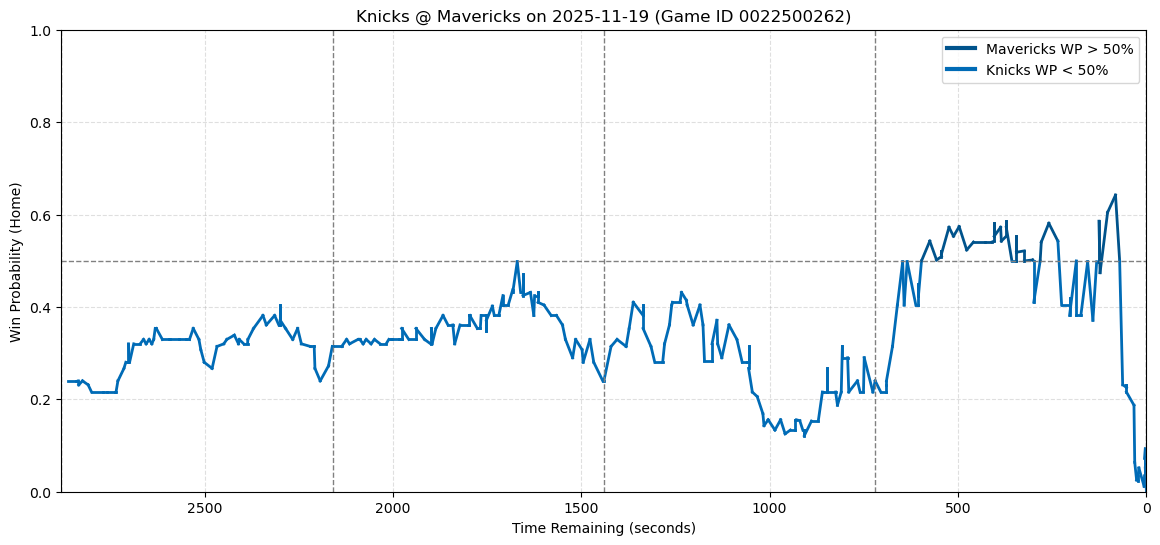

In [ ]:
def plot_win_prob_esque(
    game_states,
    breaks,
    GAME_ID,
    team_info,
    start_of_game,
    team_colors_both=team_colors_both,
    home = True,
):
    # === Extract team abbreviations ===
    home_abbrev = home_team_abbr
    away_abbrev = away_team_abbr

    # === Look up colors ===
    home_color = team_colors_both.get(home_abbrev, {}).get("primary", "blue")
    away_color = team_colors_both.get(away_abbrev, {}).get("primary", "red")

    # Fallback colors if something goes wrong
    if home_color is None: home_color = "blue"
    if away_color is None: away_color = "red"

    # === Extract x/y ===
    x = game_states["seconds_remaining_game"].values
    y = game_states["p_home_win_nn"].values

    plt.figure(figsize=(14, 6))

    # Plot invisible baseline to force axes to scale correctly
    plt.plot(x, y, alpha=0)

    # === Plot colored WP segments ===
    for i in range(len(x) - 1):
        x_vals = [x[i], x[i+1]]
        y_vals = [y[i], y[i+1]]

        # Choose color based on WP midpoint
        if (y_vals[0] + y_vals[1]) / 2 >= 0.5:
            color = home_color
        else:
            color = away_color

        plt.plot(x_vals, y_vals, color=color, linewidth=2)

    # === Axes setup ===
    plt.ylim(0, 1)
    plt.xlim(start_of_game, 0)
    if home == False:
        plt.gca().invert_yaxis()

    # Quarter / OT markers
    for bx in breaks:
        plt.axvline(bx, color="gray", linestyle="--", linewidth=1)

    # 50% reference line
    plt.axhline(0.5, color="gray", linestyle="--", linewidth=1)

    # Title
    home_name = team_info["team_names"][0]
    away_name = team_info["team_names"][1]
    game_date = team_info["date"]

    title = f"{away_name} @ {home_name} on {str(game_date)[:10]} (Game ID {GAME_ID})"
    plt.title(title)
    plt.xlabel("Time Remaining (seconds)")
    plt.ylabel("Win Probability (Home)")
    plt.grid(True, linestyle="--", alpha=0.4)

    # === Legend with team colors ===
    legend_handles = [
        Line2D([0], [0], color=home_color, lw=3, label=f"{home_name} WP > 50%"),
        Line2D([0], [0], color=away_color, lw=3, label=f"{away_name} WP < 50%")
    ]
    plt.legend(handles=legend_handles, loc="best")

    plt.show()

plot_win_prob_esque(game_states=game_states, 
                    breaks=breaks, 
                    GAME_ID=GAME_ID, 
                    team_info=team_info,
                    start_of_game=start_of_game)


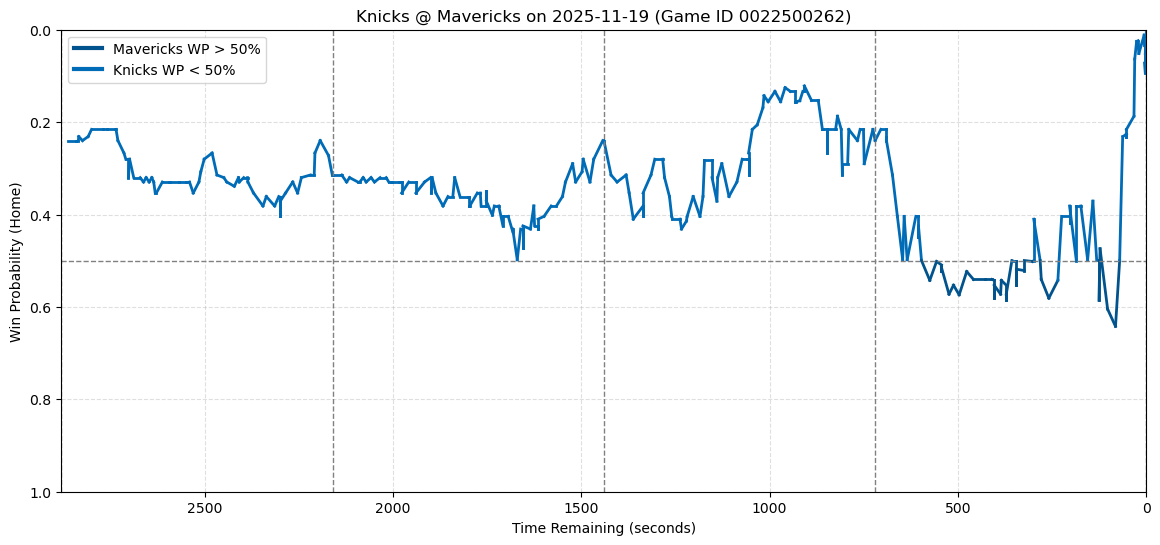

In [513]:
# Away Team (Sometimes useful for comparing to ESPN model)

plot_win_prob_esque(game_states=game_states, 
                    breaks=breaks, 
                    GAME_ID=GAME_ID, 
                    team_info=team_info,
                    start_of_game=start_of_game,
                    home = False)

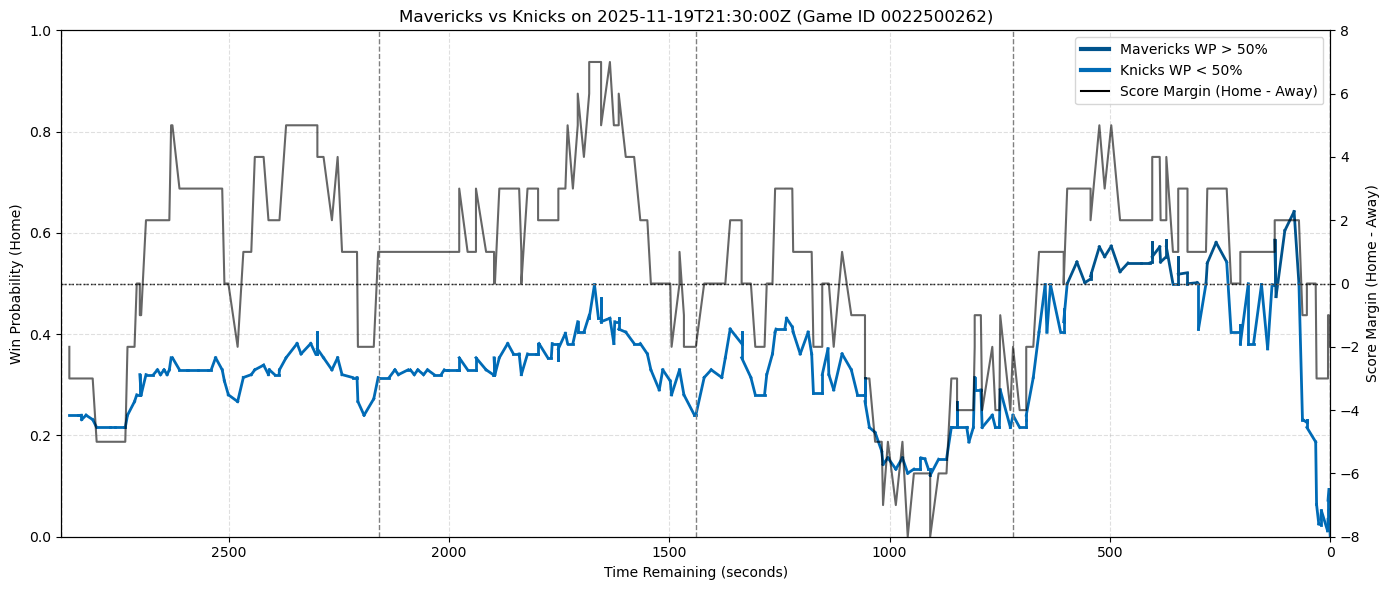

In [ ]:
def plot_win_prob_esque_with_margin(
    game_states,
    breaks,
    GAME_ID,
    team_info,
    start_of_game,
    team_colors_both=team_colors_both,
    home = True
):
    # === Extract team abbreviations & names ===
    home_abbrev = home_team_abbr
    away_abbrev = away_team_abbr
    home_name = team_info["team_names"][0]
    away_name = team_info["team_names"][1]
    game_date = team_info["date"]

    # === Look up colors (fallback to blue/red if missing) ===
    home_color = team_colors_both.get(home_abbrev, {}).get("primary", "blue")
    away_color = team_colors_both.get(away_abbrev, {}).get("primary", "red")

    if home_color is None:
        home_color = "blue"
    if away_color is None:
        away_color = "red"

    # === Extract series ===
    x = game_states["seconds_remaining_game"].values
    y_wp = game_states["p_home_win_nn"].values
    y_margin = game_states["score_diff"].values  # home - away

    fig, ax1 = plt.subplots(figsize=(14, 6))

    # Plot invisible baseline on ax1 to lock x/y scaling for WP
    ax1.plot(x, y_wp, alpha=0)

    # === WP colored segments on ax1 ===
    for i in range(len(x) - 1):
        x_vals = [x[i], x[i+1]]
        y_vals = [y_wp[i], y_wp[i+1]]

        # Decide color based on segment midpoint
        if (y_vals[0] + y_vals[1]) / 2 >= 0.5:
            color = home_color
        else:
            color = away_color

        ax1.plot(x_vals, y_vals, color=color, linewidth=2)

    # === Axis setup for WP (ax1) ===
    ax1.set_ylim(0, 1)
    ax1.set_xlim(start_of_game, 0)
    ax1.invert_xaxis()
    ax1.set_xlabel("Time Remaining (seconds)")
    ax1.set_ylabel("Win Probability (Home)")
    if home == False:
        plt.gca().invert_yaxis()

    # Quarter / OT break lines on ax1
    for bx in breaks:
        ax1.axvline(bx, color="gray", linestyle="--", linewidth=1)

    # 50% WP reference line
    ax1.axhline(0.5, color="gray", linestyle="--", linewidth=1)

    # === Score margin overlay on secondary axis (ax2) ===
    ax2 = ax1.twinx()

    # Plot score margin line
    ax2.plot(x, y_margin, color="black", linewidth=1.5, alpha=0.6)

    # Center score margin at 0
    max_abs_margin = np.nanmax(np.abs(y_margin)) if len(y_margin) > 0 else 0
    if max_abs_margin == 0:
        max_abs_margin = 1  # avoid zero-range
    ax2.set_ylim(-max_abs_margin, max_abs_margin)
    ax2.set_ylabel("Score Margin (Home - Away)", color="black")

    # Horizontal line at margin = 0
    ax2.axhline(0, color="black", linestyle=":", linewidth=1, alpha=0.7)
    if home == False:
        plt.gca().invert_yaxis()
    # === Title & grid ===
    title = f"{home_name} vs {away_name} on {game_date} (Game ID {GAME_ID})"
    ax1.set_title(title)
    ax1.grid(True, linestyle="--", alpha=0.4)

    # === Legend (combine WP colors + margin line) ===
    legend_handles = [
        Line2D([0], [0], color=home_color, lw=3, label=f"{home_name} WP > 50%"),
        Line2D([0], [0], color=away_color, lw=3, label=f"{away_name} WP < 50%"),
        Line2D([0], [0], color="black", lw=1.5, label="Score Margin (Home - Away)"),
    ]
    ax1.legend(handles=legend_handles, loc="best")
    plt.gca().invert_xaxis()

    plt.tight_layout()
    plt.show()
    
plot_win_prob_esque_with_margin(
    game_states=game_states,
    breaks=breaks,
    GAME_ID=GAME_ID,
    team_info=team_info,
    start_of_game=start_of_game,
    home = True
)

# 